# Classify chest x-rays as w/ or w/o abnormalities

In [ ]:
#@title Version notes { run: "auto" }
version_notes = "EffNet, 512 resolution, threshold 0.8" #@param {type:"string"}

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/Colab\ Notebooks/kaggle
    from setup_colab import setup_colab_for_kaggle, OUTPUT_FOLDER, WORK_FOLDER, dump_dataset_metadata
    setup_colab_for_kaggle(check_env=False, local_working=True)
except:
    print("Not in Colab")

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content of Drive Kaggle data dir (/content/drive/MyDrive/kaggle): ['/content/drive/MyDrive/kaggle/input', '/content/drive/MyDrive/kaggle/working', '/content/drive/MyDrive/kaggle/.ipynb_checkpoints', '/content/drive/MyDrive/kaggle/output']
Content of Kaggle data dir (/kaggle): ['/kaggle/input', '/kaggle/working', '/kaggle/output']
Content of Kaggle data subdir (/kaggle/input): ['/kaggle/input/cassava-model', '/kaggle/input/cassava-leaf-disease-classification', '/kaggle/input/googlebitemperedloss', '/kaggle/input/vbdyolo', '/kaggle/input/.ipynb_checkpoints', '/kaggle/input/vinbigdata', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection', '/kaggle/input/vinbigdata-chest-xray-original-png']
Content of Kaggle data subdir (/kaggle/output): ['/kaggle/output/vbdyolo_out_1_300epochs', '/

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 5.6MB/s 


In [ ]:
from pathlib import Path

from IPython.display import clear_output

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras.applications import EfficientNetB3 as EfficientNetBX
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm

INPUT_FOLDER_DATA = WORK_FOLDER / "vinbigdata-chest-xray-abnormalities-detection"
OUTPUT_FOLDER_CUR = OUTPUT_FOLDER / "vbdbinary"
INPUT_FOLDER_PNG = WORK_FOLDER / "vinbigdata"

2.4.1


Reset the GPU (free any used up memory)

In [ ]:
from numba import cuda
cuda.get_current_device().reset()

In [ ]:
!nvidia-smi

Fri Mar 19 16:12:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |      2MiB / 16280MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gpu = tf.config.list_physical_devices("GPU")[0]
tf.config.experimental.set_memory_growth(gpu, False)

## Prepare data for binary classification

In [ ]:
!pip install git+https://github.com/Witalia008/kaggle-api.git@fix-datasets-download-file-unzip
clear_output()

Download the competition dataset's `train.csv`

In [ ]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train.csv -p {INPUT_FOLDER_DATA} --unzip

  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 154MB/s]


Download the dataset with PNG images 512x512

In [ ]:
!kaggle datasets download xhlulu/vinbigdata -p {INPUT_FOLDER_PNG} --unzip

 99% 1.93G/1.94G [00:15<00:00, 133MB/s]
100% 1.94G/1.94G [00:15<00:00, 132MB/s]


In [ ]:
train_df = pd.read_csv(INPUT_FOLDER_DATA / "train.csv")
train_df = train_df[["image_id", "class_name"]].groupby("image_id").agg(lambda x: "normal" if (x.to_numpy() == "No finding").all() else "abnormal").reset_index()
train_df["image_file_name"] = train_df["image_id"].astype(str) + ".png"
display(train_df.sample(5))
print(train_df.shape)
display(train_df["class_name"].value_counts())

,image_id,class_name,image_file_name
3369,3951bee26f75813c40d3b5dc4fd661d6,normal,3951bee26f75813c40d3b5dc4fd661d6.png
103,01b0d8debe488c18e4c79624dd8a4f30,normal,01b0d8debe488c18e4c79624dd8a4f30.png
13413,e33ce975b5a636df54a8a1f592410b0c,abnormal,e33ce975b5a636df54a8a1f592410b0c.png
3601,3dada1f2165d5a58e7d79d77da9b195c,normal,3dada1f2165d5a58e7d79d77da9b195c.png
810,0df187b5072103a0919c1a34be03e7ed,abnormal,0df187b5072103a0919c1a34be03e7ed.png


(15000, 3)


normal      10606
abnormal     4394
Name: class_name, dtype: int64

## Setup image loading and augmentation

In [ ]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16

In [ ]:
generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2,
    data_format="channels_last"
)

# Use color_mode=rgb to have the images converted from grayscale.
train_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="training"
)

valid_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

Found 12000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


Which class is in fact a "positive"

In [ ]:
train_dataset.class_indices

{'abnormal': 0, 'normal': 1}

## Configure the model

In [ ]:
input = Input(IMAGE_SIZE + (3,))

backbone = EfficientNetBX(include_top=False, weights="imagenet", input_tensor=input, pooling="avg")

backbone.trainable = False
# Unfreeze only some of layers.
for layer in backbone.layers:
    # BatchNormalization should be always kept frozen.
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model = Sequential([
    backbone,
    Dropout(0.2),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

print(model.summary())

43941888/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 11,573,040
Trainable params: 788,481
Non-tr

In [ ]:
optimizer = Adam(learning_rate=1e-3)
loss = BinaryCrossentropy(label_smoothing=0.01)
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="prec"),
    Recall(name="rec"),
    AUC(name="pr_auc", curve="PR")
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the model

In [ ]:
OUTPUT_FOLDER_CUR.mkdir(parents=True, exist_ok=True)

model_checkpoint = ModelCheckpoint(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

results = model.fit(
    train_dataset,
    epochs=30,
    shuffle=False, # Already shuffled by datagen
    callbacks=[model_checkpoint, early_stopping, reduce_lr_on_plateau, tqdm_callback],
    validation_data=valid_dataset,
    verbose=1
)

model.save(OUTPUT_FOLDER_CUR / "chest_xray_binary.h5")

Epoch 1/30
Epoch 1/30


750/750 [==============================] - 1037s 1s/step - loss: 0.5485 - accuracy: 0.7611 - prec: 0.8295 - rec: 0.8322 - pr_auc: 0.8930 - val_loss: 0.3318 - val_accuracy: 0.8653 - val_prec: 0.8616 - val_rec: 0.9624 - val_pr_auc: 0.9643

Epoch 2/30
Epoch 2/30


750/750 [==============================] - 994s 1s/step - loss: 0.4011 - accuracy: 0.8262 - prec: 0.8505 - rec: 0.9124 - pr_auc: 0.9368 - val_loss: 0.3114 - val_accuracy: 0.8797 - val_prec: 0.8826 - val_rec: 0.9553 - val_pr_auc: 0.9657

Epoch 3/30
Epoch 3/30


750/750 [==============================] - 938s 1s/step - loss: 0.3951 - accuracy: 0.8313 - prec: 0.8562 - rec: 0.9155 - pr_auc: 0.9372 - val_loss: 0.3073 - val_accuracy: 0.8793 - val_prec: 0.8991 - val_rec: 0.9324 - val_pr_auc: 0.9686

Epoch 4/30
Epoch 4/30


750/750 [==============================] - 937s 1s/step - loss: 0.3850 - accuracy: 0.8331 - prec: 0.8569 - rec: 0.9171 - pr_auc: 0.9431 - val_loss: 0.3053 - val_accuracy: 0.8857 - val_prec: 0.8963 - val_rec: 0.9462 - val_pr_auc: 0.9672

Epoch 5/30
Epoch 5/30


750/750 [==============================] - 941s 1s/step - loss: 0.3802 - accuracy: 0.8416 - prec: 0.8629 - rec: 0.9232 - pr_auc: 0.9445 - val_loss: 0.3704 - val_accuracy: 0.8420 - val_prec: 0.8217 - val_rec: 0.9891 - val_pr_auc: 0.9702

Epoch 6/30
Epoch 6/30


750/750 [==============================] - 940s 1s/step - loss: 0.3573 - accuracy: 0.8541 - prec: 0.8734 - rec: 0.9283 - pr_auc: 0.9519 - val_loss: 0.3119 - val_accuracy: 0.8717 - val_prec: 0.8845 - val_rec: 0.9396 - val_pr_auc: 0.9672

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 7/30
Epoch 7/30


750/750 [==============================] - 947s 1s/step - loss: 0.3627 - accuracy: 0.8432 - prec: 0.8707 - rec: 0.9122 - pr_auc: 0.9511 - val_loss: 0.2936 - val_accuracy: 0.8813 - val_prec: 0.8856 - val_rec: 0.9539 - val_pr_auc: 0.9725

Epoch 8/30
Epoch 8/30


750/750 [==============================] - 940s 1s/step - loss: 0.3522 - accuracy: 0.8550 - prec: 0.8737 - rec: 0.9295 - pr_auc: 0.9533 - val_loss: 0.2879 - val_accuracy: 0.8857 - val_prec: 0.9014 - val_rec: 0.9396 - val_pr_auc: 0.9737

Epoch 9/30
Epoch 9/30


750/750 [==============================] - 941s 1s/step - loss: 0.3662 - accuracy: 0.8412 - prec: 0.8646 - rec: 0.9170 - pr_auc: 0.9507 - val_loss: 0.2812 - val_accuracy: 0.8917 - val_prec: 0.9089 - val_rec: 0.9396 - val_pr_auc: 0.9749

Epoch 10/30
Epoch 10/30


750/750 [==============================] - 982s 1s/step - loss: 0.3444 - accuracy: 0.8600 - prec: 0.8795 - rec: 0.9303 - pr_auc: 0.9564 - val_loss: 0.2813 - val_accuracy: 0.8907 - val_prec: 0.8901 - val_rec: 0.9629 - val_pr_auc: 0.9753

Epoch 11/30
Epoch 11/30


750/750 [==============================] - 997s 1s/step - loss: 0.3405 - accuracy: 0.8570 - prec: 0.8770 - rec: 0.9278 - pr_auc: 0.9564 - val_loss: 0.2803 - val_accuracy: 0.8860 - val_prec: 0.8846 - val_rec: 0.9629 - val_pr_auc: 0.9762

Epoch 12/30
Epoch 12/30


750/750 [==============================] - 965s 1s/step - loss: 0.3417 - accuracy: 0.8617 - prec: 0.8796 - rec: 0.9327 - pr_auc: 0.9581 - val_loss: 0.2704 - val_accuracy: 0.8960 - val_prec: 0.8974 - val_rec: 0.9615 - val_pr_auc: 0.9786

Epoch 13/30
Epoch 13/30


750/750 [==============================] - 970s 1s/step - loss: 0.3378 - accuracy: 0.8586 - prec: 0.8803 - rec: 0.9282 - pr_auc: 0.9599 - val_loss: 0.2784 - val_accuracy: 0.8930 - val_prec: 0.8932 - val_rec: 0.9624 - val_pr_auc: 0.9754

Epoch 14/30
Epoch 14/30


750/750 [==============================] - 950s 1s/step - loss: 0.3370 - accuracy: 0.8655 - prec: 0.8877 - rec: 0.9273 - pr_auc: 0.9610 - val_loss: 0.2692 - val_accuracy: 0.8957 - val_prec: 0.9079 - val_rec: 0.9472 - val_pr_auc: 0.9775

Epoch 15/30
Epoch 15/30


750/750 [==============================] - 954s 1s/step - loss: 0.3417 - accuracy: 0.8588 - prec: 0.8800 - rec: 0.9259 - pr_auc: 0.9585 - val_loss: 0.2707 - val_accuracy: 0.8933 - val_prec: 0.9024 - val_rec: 0.9505 - val_pr_auc: 0.9769

Epoch 16/30
Epoch 16/30


750/750 [==============================] - 1007s 1s/step - loss: 0.3300 - accuracy: 0.8646 - prec: 0.8846 - rec: 0.9304 - pr_auc: 0.9616 - val_loss: 0.2736 - val_accuracy: 0.8977 - val_prec: 0.9070 - val_rec: 0.9515 - val_pr_auc: 0.9771

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 17/30
Epoch 17/30


750/750 [==============================] - 1018s 1s/step - loss: 0.3205 - accuracy: 0.8690 - prec: 0.8920 - rec: 0.9291 - pr_auc: 0.9653 - val_loss: 0.2675 - val_accuracy: 0.8987 - val_prec: 0.9109 - val_rec: 0.9481 - val_pr_auc: 0.9782

Epoch 18/30
Epoch 18/30


750/750 [==============================] - 1022s 1s/step - loss: 0.3148 - accuracy: 0.8690 - prec: 0.8901 - rec: 0.9292 - pr_auc: 0.9669 - val_loss: 0.2598 - val_accuracy: 0.9043 - val_prec: 0.9188 - val_rec: 0.9472 - val_pr_auc: 0.9796

Epoch 19/30
Epoch 19/30


750/750 [==============================] - 1009s 1s/step - loss: 0.3176 - accuracy: 0.8721 - prec: 0.8934 - rec: 0.9315 - pr_auc: 0.9648 - val_loss: 0.2590 - val_accuracy: 0.8987 - val_prec: 0.9143 - val_rec: 0.9439 - val_pr_auc: 0.9800

Epoch 20/30
Epoch 20/30


750/750 [==============================] - 1000s 1s/step - loss: 0.3269 - accuracy: 0.8627 - prec: 0.8842 - rec: 0.9257 - pr_auc: 0.9631 - val_loss: 0.2553 - val_accuracy: 0.9057 - val_prec: 0.9162 - val_rec: 0.9524 - val_pr_auc: 0.9813

Epoch 21/30
Epoch 21/30


750/750 [==============================] - 1007s 1s/step - loss: 0.3233 - accuracy: 0.8670 - prec: 0.8873 - rec: 0.9306 - pr_auc: 0.9638 - val_loss: 0.2608 - val_accuracy: 0.9033 - val_prec: 0.9164 - val_rec: 0.9486 - val_pr_auc: 0.9794

Epoch 22/30
Epoch 22/30


750/750 [==============================] - 992s 1s/step - loss: 0.3292 - accuracy: 0.8659 - prec: 0.8878 - rec: 0.9297 - pr_auc: 0.9635 - val_loss: 0.2650 - val_accuracy: 0.8963 - val_prec: 0.9058 - val_rec: 0.9510 - val_pr_auc: 0.9777

Epoch 00022: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 23/30
Epoch 23/30


750/750 [==============================] - 981s 1s/step - loss: 0.3253 - accuracy: 0.8652 - prec: 0.8834 - rec: 0.9314 - pr_auc: 0.9626 - val_loss: 0.2530 - val_accuracy: 0.9050 - val_prec: 0.9204 - val_rec: 0.9462 - val_pr_auc: 0.9808

Epoch 24/30
Epoch 24/30


750/750 [==============================] - 984s 1s/step - loss: 0.3217 - accuracy: 0.8668 - prec: 0.8917 - rec: 0.9253 - pr_auc: 0.9642 - val_loss: 0.2584 - val_accuracy: 0.9007 - val_prec: 0.9126 - val_rec: 0.9491 - val_pr_auc: 0.9804

Epoch 25/30
Epoch 25/30


750/750 [==============================] - 986s 1s/step - loss: 0.3200 - accuracy: 0.8704 - prec: 0.8900 - rec: 0.9305 - pr_auc: 0.9647 - val_loss: 0.2595 - val_accuracy: 0.9083 - val_prec: 0.9181 - val_rec: 0.9543 - val_pr_auc: 0.9792

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 26/30
Epoch 26/30


750/750 [==============================] - 979s 1s/step - loss: 0.3201 - accuracy: 0.8634 - prec: 0.8876 - rec: 0.9252 - pr_auc: 0.9653 - val_loss: 0.2529 - val_accuracy: 0.9067 - val_prec: 0.9179 - val_rec: 0.9520 - val_pr_auc: 0.9809

Epoch 27/30
Epoch 27/30


750/750 [==============================] - 1014s 1s/step - loss: 0.3224 - accuracy: 0.8683 - prec: 0.8872 - rec: 0.9315 - pr_auc: 0.9651 - val_loss: 0.2595 - val_accuracy: 0.9007 - val_prec: 0.9153 - val_rec: 0.9458 - val_pr_auc: 0.9797

Epoch 28/30
Epoch 28/30


750/750 [==============================] - 996s 1s/step - loss: 0.3180 - accuracy: 0.8712 - prec: 0.8901 - rec: 0.9341 - pr_auc: 0.9654 - val_loss: 0.2658 - val_accuracy: 0.9017 - val_prec: 0.9139 - val_rec: 0.9491 - val_pr_auc: 0.9776

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 29/30
Epoch 29/30


750/750 [==============================] - 983s 1s/step - loss: 0.3157 - accuracy: 0.8693 - prec: 0.8923 - rec: 0.9279 - pr_auc: 0.9673 - val_loss: 0.2611 - val_accuracy: 0.9023 - val_prec: 0.9155 - val_rec: 0.9481 - val_pr_auc: 0.9788
Restoring model weights from the end of the best epoch.

Epoch 00029: early stopping



## Learning curves and model performance

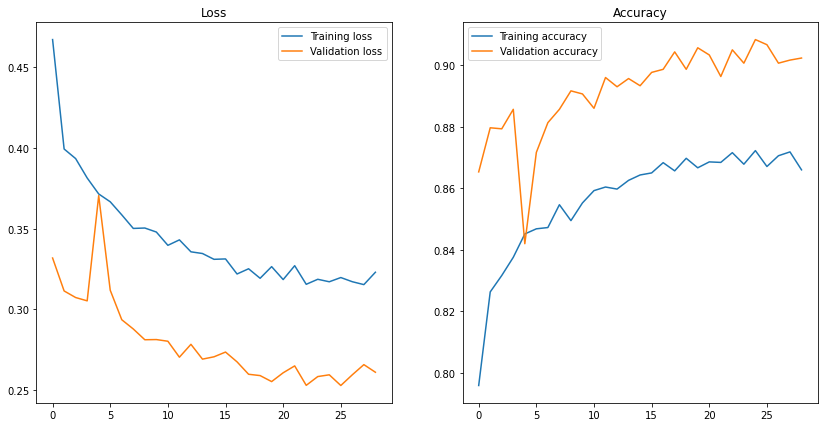

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(x=results.epoch, y=results.history["loss"], ax=ax[0], label="Training loss")
sns.lineplot(x=results.epoch, y=results.history["val_loss"], ax=ax[0], label="Validation loss")
ax[0].set_title("Loss")

sns.lineplot(x=results.epoch, y=results.history["accuracy"], ax=ax[1], label="Training accuracy")
sns.lineplot(x=results.epoch, y=results.history["val_accuracy"], ax=ax[1], label="Validation accuracy")
_ = ax[1].set_title("Accuracy")

## Evaluate
Get predictions for validation set and print classification report

In [ ]:
THRESHOLD = 0.8

In [ ]:
model.load_weights(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5")

In [ ]:
[val_loss, val_accuracy, val_prec, val_rec, val_pr_auc] = model.evaluate(valid_dataset, callbacks=[tfa.callbacks.TQDMProgressBar()], verbose=1)

188/188 [==============================] - 197s 1s/step - loss: 0.2630 - accuracy: 0.8970 - prec: 0.9107 - rec: 0.9458 - pr_auc: 0.9782



In [ ]:
valid_pred_probabilities = model.predict(
    valid_dataset,
    callbacks=[tfa.callbacks.TQDMProgressBar()]
)

In [ ]:
valid_predictions = (valid_pred_probabilities > THRESHOLD).reshape(-1).astype(np.int32)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(valid_dataset.classes, valid_predictions, target_names=list(train_dataset.class_indices.keys()),))

              precision    recall  f1-score   support

    abnormal       0.70      0.93      0.80       898
      normal       0.97      0.83      0.89      2102

    accuracy                           0.86      3000
   macro avg       0.83      0.88      0.84      3000
weighted avg       0.89      0.86      0.86      3000



Text(0.5, 1.0, 'Precision-Recall Curve')

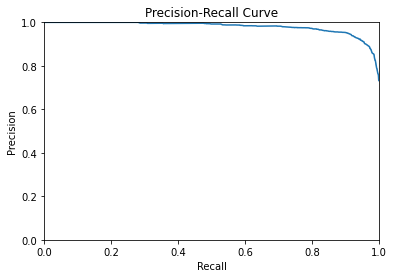

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(valid_dataset.classes, valid_pred_probabilities)

ax = sns.lineplot(x=recall, y=precision)
ax.set(xlabel="Recall", ylabel="Precision")
ax.axis([0, 1, 0, 1])
ax.set_title("Precision-Recall Curve")

## Predict

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_id_to_name = {v: k for k, v in train_dataset.class_indices.items()}
images = list((INPUT_FOLDER_PNG / "test").iterdir())
results = pd.DataFrame(columns=["image_id", "class_name"])

for image_file in tqdm(images, total=len(images)):
    image = load_img(image_file, target_size=IMAGE_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    pred_prob = model.predict(image)
    pred = int((pred_prob > THRESHOLD).squeeze())

    results = results.append({"image_id": image_file.stem, "class_name": class_id_to_name[pred]}, ignore_index=True)

results.to_csv(OUTPUT_FOLDER_CUR / "prediction.csv", index=False)
results.sample(5)

,image_id,class_name
2663,7aa301c90a61603f9b5e2e05a88b4204,abnormal
1692,407a0f9b955a811bd3dbb459a8ac7576,normal
2668,5be05d9818c57db3635e33dca8315507,normal
86,271290de7e7e4fb8aa1c31327f48f4b5,normal
2737,008bdde2af2462e86fd373a445d0f4cd,abnormal


## Store output to Kaggle

In [ ]:
dump_dataset_metadata("witalia", "vbdbinary", OUTPUT_FOLDER_CUR)

# !kaggle datasets create -p {OUTPUT_FOLDER_CUR} -r zip
!kaggle datasets version -m "{version_notes}" -p {OUTPUT_FOLDER_CUR} -r zip

Starting upload for file chest_xray_binary.h5
100% 50.8M/50.8M [00:06<00:00, 7.97MB/s]
Upload successful: chest_xray_binary.h5 (51MB)
Starting upload for file prediction.csv
100% 120k/120k [00:04<00:00, 28.3kB/s]
Upload successful: prediction.csv (120KB)
Starting upload for file chest_xray_binary_best.h5
100% 50.8M/50.8M [00:05<00:00, 9.46MB/s]
Upload successful: chest_xray_binary_best.h5 (51MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/witalia/vbdbinary
